## Maximum cut problem 

The MaxCut problem is one of the most famous NP-complete problems in combinatorial optimization. Given an undirected graph $G(V, E)$ with a vertex set $V$ and an edge set $E$, the Max Cut problem seeks to partition $V$ into two sets such that the number of edges between the two sets (considered to be severed by the cut), is a large as possible. Applications can be found (for example) in clustering problems for marketing purposes or portfolio optimization problems in finance.

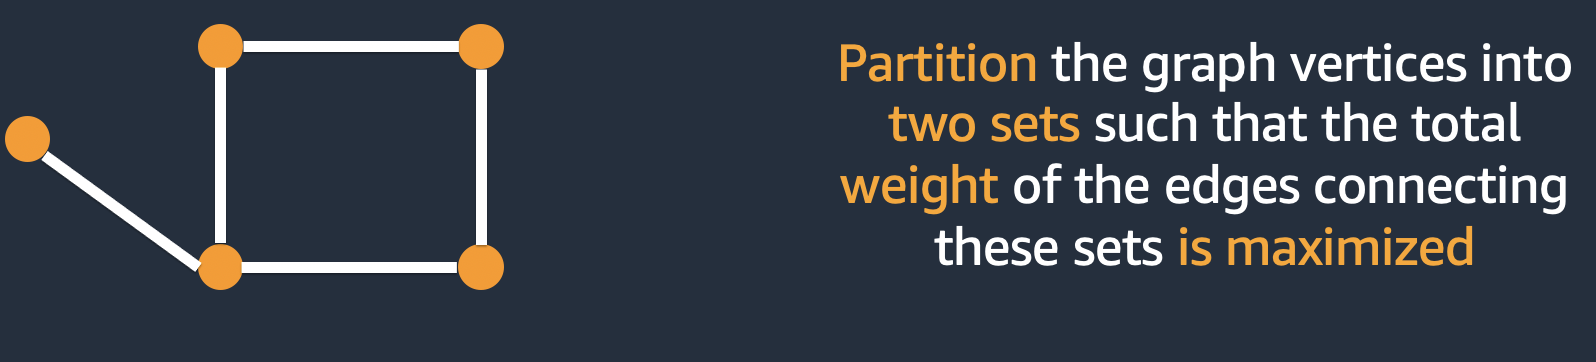

## Solving MaxCut on DWave  

In [ ]:
# Imports 
import boto3
import numpy as np
import json
from braket.aws import AwsDevice
from braket.ocean_plugin import BraketSampler, BraketDWaveSampler

import networkx as nx
import dwave_networkx as dnx
from dimod.binary_quadratic_model import BinaryQuadraticModel
from dwave.system.composites import EmbeddingComposite
from collections import defaultdict

import matplotlib.pyplot as plt
# magic word for producing visualizations in notebook
%matplotlib inline

In [ ]:
# S3 destination
my_bucket = "<your amazon braket bucket name>" # the name of the bucket
my_prefix = "<folder in the bucket>" # the name of the folder in the bucket
s3_folder = (my_bucket, my_prefix)

In [ ]:
# Setting up the backend
device = AwsDevice("arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6")
print('Device:', device)

In [ ]:
# helper function to plot graph
def get_graph(graph, pos):
    """
    plot colored graph for given solution
    """
   # nodes
    nx.draw_networkx_nodes(graph, pos, node_size=700)

    # edges
    nx.draw_networkx_edges(graph, pos)

    # labels
    nx.draw_networkx_labels(graph, pos, font_size=20, font_family='sans-serif')

    # plot the graph
    plt.axis('off')
    plt.show();

## Setting up the graph for DWave

In [ ]:
# Create empty graph
G = nx.Graph()

# Add edges to the graph (also adds nodes)
G.add_edges_from([(1,2),(1,4),(1,5),(2,3),(3,4)])

# plot graph
pos = nx.spring_layout(G)
# plot graph with labels
get_graph(G, pos)

# ------- Set up our QUBO dictionary -------

# Initialize our Q matrix
Q = defaultdict(int)

# Update Q matrix for every edge in the graph
for u, v in G.edges:
    Q[(u,u)]+= -1
    Q[(v,v)]+= -1
    Q[(u,v)]+= 2

## Running QUBO on DWave

In [ ]:
# Set up DWave parameters
chainstrength = 8
numruns = 100

# Run the QUBO on the Braket solver from your config file
# set sampler
sampler = BraketDWaveSampler(s3_folder,'arn:aws:braket:::device/qpu/d-wave/DW_2000Q_6')
sampler = EmbeddingComposite(sampler)
response = sampler.sample_qubo(Q, chain_strength=chainstrength, num_reads=numruns)
energies = iter(response.data())

# ------- Print results to user -------
print('-' * 60)
print('{:>15s}{:>15s}{:^15s}{:^15s}'.format('Set 0','Set 1','Energy','Cut Size'))
print('-' * 60)
for line in response:
    S0 = [k for k,v in line.items() if v == 0]
    S1 = [k for k,v in line.items() if v == 1]
    E = next(energies).energy
    print('{:>15s}{:>15s}{:^15s}{:^15s}'.format(str(S0),str(S1),str(E),str(int(-1*E))))

# ------- Display results to user -------
# Grab best result
# Note: "best" result is the result with the lowest energy
# Note2: the look up table (lut) is a dictionary, where the key is the node index
#   and the value is the set label. For example, lut[5] = 1, indicates that
#   node 5 is in set 1 (S1).
lut = response.lowest().first.sample

# Interpret best result in terms of nodes and edges
S0 = [node for node in G.nodes if not lut[node]]
S1 = [node for node in G.nodes if lut[node]]
cut_edges = [(u, v) for u, v in G.edges if lut[u]!=lut[v]]
uncut_edges = [(u, v) for u, v in G.edges if lut[u]==lut[v]]

# Display best result
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, nodelist=S0, node_color='r')
nx.draw_networkx_nodes(G, pos, nodelist=S1, node_color='c')
nx.draw_networkx_edges(G, pos, edgelist=cut_edges, style='dashdot', alpha=0.5, width=3)
nx.draw_networkx_edges(G, pos, edgelist=uncut_edges, style='solid', width=3)
nx.draw_networkx_labels(G, pos)

filename = "maxcut_plot.png"
plt.savefig(filename, bbox_inches='tight')
print("\nYour plot is saved to {}".format(filename))

## Solving MaxCut using Quantum Approximate Optimization

__Quantum Approximate Optimization Algorithm (QAOA)__: MaxCut problem enjoys a natural mapping onto quantum Ising model. Using QAOA we would like to find the lowest energy state of the Hamiltonian encoding the optimization problem

$$\hat{H}_{C}=\sum_{i>j} J_{i,j} \sigma_{i}^{z} \sigma_{j}^{z},$$

which can be written as a matrix of size $(2^{N}, 2^{N})$ with diagonal elements only corresponding to all possible classical values for the cost function $H_{C}$. 
The ground state of $\hat{H}_{C}$ corresponds to the optimal solution of the classical combinatorial problem.

__QAOA ansatz__: Finding this ground state exactly is hard. 
To approximate this groundstate, QAOA prepares a parametrized ansatz state (corresponding to a parameterized  gate  sequence),  whose  parameters  are iteratively updated by a classical optimizer in a closed loop. 
Specifically, QAOA involves a specific ansatz wavefunction parametrized by a parameter family $(\vec{\beta}, \vec{\gamma})$, embedded into a larger classical optimization loop to find the optimal values for these parameters. 
As shown in Ref.[1], good approximate solutions to the problem class considered here can be found by preparing the variational state 

$$|\gamma, \beta \rangle = U_{x}(\beta_{p})U_{zz}(\gamma_{p}) \cdots U_{x}(\beta_{1})U_{zz}(\gamma_{1}) |s\rangle$$

with single qubit rotations induced by $U_{x}(\beta) = \exp(-i\beta \sum_{i}\sigma_{i}^{x})$, 
and interactions described by $U_{zz}(\gamma) = \exp(-i\gamma H_{C})$,
starting initially from a product of $\sigma^{x}$ eigenstates, i.e.,
$|s\rangle =|-,-,\dots\rangle$, with $|-\rangle = (|0\rangle -|1\rangle  )/\sqrt{2}$. 
The family of states $|\gamma, \beta \rangle$ is prepared by alternating single-qubit operations $U_{x}(\beta_{p})$ with targeted spin-spin interactions generated by the cost Hamiltonian $H_{C}$. 
The depth $p$ can be interpreted as a hyperparameter. 
For $p$ layers of QAOA blocks, there are $2p$ classical parameters to optimize over, 
since each layer $k$ is characterized by just two variational parameters, $\gamma_{k}$ and $\beta_{k}$. 
The preparation step outlined above is followed by a measurement in the computational basis, giving a classical string $z$, with which one can evaluate the objective function $H_{C}$ of the underlying combinatorial problem at hand. 
Taking several measurements shots one can build the expectation value $E(\beta, \gamma) = \langle H_{C} \rangle$ that we report as the objective function to the classical minimizer (while other choices could be possible as well). 
Repeating this procedure will provide an optimized string $z$, with the quality of the result improving as the depth of the quantum circuit $\sim 2p$ is increased [1]. 
In fact, in principle (in the absence of noise and other imperfections), QAOA can reach the global optimum of any cost function in the limit $p \rightarrow \infty$ [1], approaching the adiabatic protocol. 
Thus, in theory the computational power of QAOA increases with $p$, but in practice the number of layers that can be executed without errors on NISQ devices is limited due noise and imperfections. 

__Optimization__: Since we are primarily interested in solving the classical optimization problem, within this routine it is sufficient to keep track of the best classical bitstring. 
This means that the wavefunction prepared by the quantum circuit $|\gamma, \beta \rangle$ has to have some overlap with the optimal solution $|z^{*} \rangle$ that we can read out as bitstring $z^{*}$ in the measurement shots. 
To this end, in principle (i.e., without any training), we could just sample from a completely uniform state that is prepared in a superposition of all computational basis states, as prepared by applying Hadamard gates to all qubits: $|\mathrm{uniform}\rangle = 1/\sqrt{2^{N}}\sum_{i}|z_{i}\rangle$. 
In that case (assuming a single optimal solution) the success probability per shot amounts to $p_{\mathrm{success}}=1/2^{N}$. 
We can then amplify our success chances by just taking many measurement shots. 
For large systems, however, this approach is not scalable as we would need to take an exponentially increasing number of measurements. 
That is why we train our circuits, update the parameters, with the goal to increase our success chances to find the optimal bitstring. 
We can quantify our success chances as follows [6]. 
For a given wavefunction $|\gamma, \beta \rangle$ the probability to find the optimal solution in a single shot is given by 

$$ p_{\mathrm{success}}(\gamma, \beta) = |\langle z^{*}|\gamma, \beta \rangle |^{2},$$

where $z^{*}$ denotes the optimal bitstring. 
If we perform $M$ repeated measurements, the overall probability $P$ for observing this solution at least once is given by 

$$ P = 1 - (1-p_{\mathrm{success}}(\gamma, \beta))^{M}, $$ 

since the term $(1-p_{\mathrm{success}}(\gamma, \beta))^{M}$ gives the probability of _not_ obtaining $z^{*}$ in repeated $M$ trials. 
Therefore, to have an overall success chance up to $\epsilon$ close to 100%, i.e., $P \geq 1-\epsilon$, the number of required shots has to be 

$$ M \geq \frac{\log(\epsilon)}{\log(1-p_{\mathrm{success}}(\gamma, \beta))}.$$

Let us illustrate this results as follows: 
If we do not know anything and just resort to a uniform superposition $|\mathrm{uniform}\rangle$, for a small system with $N=10$ qubits we can find the optimal solutions with 80% success probability by taking at least $\sim 1650$ shots. 
For just $N=20$ qubits, however, this number amounts to $\sim 1.7 \times 10^{6}$, making this naive approach unfeasible. 
Conversely, if we can train the quantum circuit to obtain $p_{\mathrm{success}}(\gamma, \beta) \sim 0.1$, we only need $\sim 15$ shots to have $P\geq 80\%$. 
Below we will track and illustrate the best classical optimum as our algorithm proceeds towards a local or (ideally) global optimum.  

__Objective function__: Finally, some more details on the definition of the cost function are in order. 
Following the standard approach [1, 4], QAOA tries to minimize the expectation value $\langle \hat{H}_{C} \rangle$, but does _not_ explicitly maximize the success probability [6]. 
However, a low expectation value for $\langle \hat{H}_{C} \rangle$ does not necessarily translate to a high success probability $p_{\mathrm{success}}(\gamma, \beta)$, as can be understood from the following example:
Consider (for example) a variational state that is a linear combination of low energy excited eigenstates of the cost Hamiltonian $\hat{H}_{C}$ other than the ground state $|z^{*}\rangle$. 
By definition, this state will have a relatively low expectation value $\langle \hat{H}_{C} \rangle$ while the success probability is zero (as this low energy state does not have any overlap with the ground state). 
Similarly, a variational state that is a linear combination of the ground state with very high energy eigenstates could have a high success probability $p_{\mathrm{success}}(\gamma, \beta)$, while (at the same time) reporting a high cost value to the classical optimizer.
To address this issue, alternative methods for the optimization of the variational parameters have recently been proposed. 
While for simplicity we follow the majority of the literature and take $\langle \hat{H}_{C} \rangle$ as cost value that we report to the classical optimizer, here we do mention a potential alternative for future research: 
One approach is to use the Gibbs objective function, defined as $\mathrm{cost}=-\mathrm{log} \langle \exp(-\eta \hat{H}_{C})\rangle$, with the hyperparameter $\eta>0$ [7]. 
As compared to the simple expectation value $\langle \hat{H}_{C} \rangle$, this definition of the cost value shows stronger rewards for low energy states, thereby increasing the success probability. 

In [ ]:
!pip install seaborn

In [ ]:
# Additional imports 
from scipy.optimize import minimize
import time
from datetime import datetime
import seaborn as sns

# AWS imports: Import Braket SDK modules
import boto3
from braket.circuits import Circuit, Observable
from braket.aws import AwsSession, AwsDevice
from braket.devices import LocalSimulator
    
# Set up device: Local Simulator
device = LocalSimulator()

# set up the device to be the managed simulator
#device = AwsDevice("arn:aws:braket:::device/quantum-simulator/amazon/sv1")

# set up the device to be the IonQ quantum computer
#device = AwsDevice("arn:aws:braket:::device/qpu/ionq/ionQdevice")

## Setup the graph for QAOA 

In [ ]:
# define graph object

e = [(1,2),(1,4),(1,5),(2,3),(3,4)]
G = nx.Graph(e)
pos = nx.spring_layout(G)

# choose weigths
for (u, v) in G.edges():
    G.edges[u,v]['weight'] = 1.0 #random.uniform(0, 1)
# draw graph
nx.draw(G, pos)
plt.show()

In [ ]:
# set Ising matrix 
J = np.array([[0., 1., 0., 1., 1.],[1., 0., 1., 0., 0.],[0., 1., 0., 1., 0.],[1., 0., 1., 0., 0.],[1., 0., 0., 0., 0.]])

# plot Ising matrix
plt.figure(1, figsize=[7, 5])
sns.heatmap(J, annot=True,  linewidths=.5, cmap="YlGnBu", annot_kws = {'alpha': 1})
plt.title('Ising distance matrix');
plt.tight_layout();

## QAOA circuit builder functions  

In [ ]:
# function to implement evolution with driver Hamiltonian
def driver(beta, n_qubits):
    """
    Returns circuit for driver Hamiltonian U(Hb, beta)
    """
    # instantiate circuit object
    circ = Circuit()

    for qubit in range(n_qubits):
        gate = Circuit().rx(qubit, 2*beta)
        circ.add(gate)

    return circ


# helper function for evolution with cost Hamiltonian
def cost_circuit(gamma, n_qubits, ising, device):
    """
    returns circuit for evolution with cost Hamiltonian
    """
    # instantiate circuit object
    circ = Circuit()

    # get all non-zero entries (edges) from Ising matrix
    idx = ising.nonzero()
    edges = list(zip(idx[0], idx[1]))

    # apply ZZ gate for every edge (with corresponding interation strength)
    for qubit_pair in edges:
        # get interaction strength from Ising matrix
        int_strength = ising[qubit_pair[0], qubit_pair[1]]
        # for Rigetti we decompose ZZ using CNOT gates
        if device.name == 'Aspen-8':
            gate = ZZgate(qubit_pair[0], qubit_pair[1], gamma*int_strength)
            circ.add(gate)
        # classical simulators and IonQ support ZZ gate
        else:
            gate = Circuit().zz(qubit_pair[0], qubit_pair[1], angle=2*gamma*int_strength)
            circ.add(gate)

    return circ

# function that computes cost function for given params
def objective_function(params, device, ising, n_qubits, n_shots, tracker, s3_folder, verbose):
    """
    objective function takes a list of variational parameters as input,
    and returns the cost associated with those parameters
    """

    if verbose:
        print('==================================' * 2)
        print('Calling the quantum circuit. Cycle:', tracker['count'])

    # get a quantum circuit instance from the parameters
    qaoa_circuit = circuit(params, device, n_qubits, ising)
   
    # classically simulate the circuit
    # execute the correct device.run call depending on whether the backend is local or cloud based
    if device.name == 'DefaultSimulator':
        task = device.run(qaoa_circuit, shots=n_shots)
    else:
        task = device.run(qaoa_circuit, s3_folder,
                          shots=n_shots, poll_timeout_seconds=3*24*60*60)

    # get result for this task
    result = task.result()

    # get metadata
    metadata = result.task_metadata

    # convert results (0 and 1) to ising (-1 and 1)
    meas_ising = result.measurements
    meas_ising[meas_ising == 0] = -1

    # get all energies (for every shot): (n_shots, 1) vector
    all_energies = np.diag(np.dot(meas_ising, np.dot(ising, np.transpose(meas_ising))))

    # find minimum and corresponding classical string
    energy_min = np.min(all_energies)
    tracker['opt_energies'].append(energy_min)
    optimal_string = meas_ising[np.argmin(all_energies)]
    tracker['opt_bitstrings'].append(optimal_string)

    # store optimal (classical) result/bitstring
    if energy_min < tracker['optimal_energy']:
        tracker.update({'optimal_energy': energy_min})
        tracker.update({'optimal_bitstring': optimal_string})

    # store global minimum
    tracker['global_energies'].append(tracker['optimal_energy'])

    # energy expectation value
    energy_expect = np.sum(all_energies) / n_shots
    
    if verbose:
        print('Minimal energy:', energy_min)
        print('Optimal classical string:', optimal_string)
        print('Energy expectation value (cost):', energy_expect)

    # update tracker
    tracker.update({'count': tracker['count']+1, 'res': result})
    tracker['costs'].append(energy_expect)
    tracker['params'].append(params)

    return energy_expect


# The function to execute the training: run classical minimization.
def train(device, options, p, ising, n_qubits, n_shots, opt_method, tracker, s3_folder, verbose=True):
    """
    function to run QAOA algorithm for given, fixed circuit depth p
    """
    print('Starting the training.')

    print('==================================' * 2)
    print(f'OPTIMIZATION for circuit depth p={p}')

    if not verbose:
        print('Param "verbose" set to False. Will not print intermediate steps.')
        print('==================================' * 2)

    # initialize
    cost_energy = []

    # randomly initialize variational parameters within appropriate bounds
    gamma_initial = np.random.uniform(0, 2 * np.pi, p).tolist()
    beta_initial = np.random.uniform(0, np.pi, p).tolist()
    params0 = np.array(gamma_initial + beta_initial)

    # set bounds for search space
    bnds_gamma = [(0, 2 * np.pi) for _ in range(int(len(params0) / 2))]
    bnds_beta = [(0, np.pi) for _ in range(int(len(params0) / 2))]
    bnds = bnds_gamma + bnds_beta

    tracker['params'].append(params0)

    # run classical optimization (example: method='Nelder-Mead')
    result = minimize(
            objective_function, params0, 
            args=(device, ising, n_qubits, n_shots, tracker, s3_folder, verbose),
            options=options, method=opt_method, bounds=bnds
        )

    # store result of classical optimization
    result_energy = result.fun
    cost_energy.append(result_energy)
    print('Final average energy (cost):', result_energy)
    result_angle = result.x
    print('Final angles:', result_angle)
    print('Training complete.')

    return result_energy, result_angle, tracker

# function to build the QAOA circuit with depth p
def circuit(params, device, n_qubits, ising):
    """
    function to return full QAOA circuit; depends on device as ZZ implementation depends on gate set of backend
    """

    # initialize qaoa circuit with first Hadamard layer: for minimization start in |->
    circ = Circuit()
    X_on_all = Circuit().x(range(0, n_qubits))
    circ.add(X_on_all)
    H_on_all = Circuit().h(range(0, n_qubits))
    circ.add(H_on_all)

    # setup two parameter families
    circuit_length = int(len(params) / 2)
    gammas = params[:circuit_length]
    betas = params[circuit_length:]

    # add QAOA circuit layer blocks
    for mm in range(circuit_length):
        circ.add(cost_circuit(gammas[mm], n_qubits, ising, device))
        circ.add(driver(betas[mm], n_qubits))

    return circ
# helper function to plot graph
def plot_colored_graph_simple(graph, colors, pos):
    """
    plot colored graph for given colored solution
    """

    # define color scheme
    colorlist = ['#e41a1c', '#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33', '#a65628', '#f781bf']

    # draw network
    nx.draw_networkx(graph, pos, node_color=[colorlist[colors[int(node)-1]] for node in graph.nodes],
                     node_size=400, font_weight='bold', font_color='w')

    # plot the graph
    plt.axis('off');
    # plt.savefig("./figures/weighted_graph.png") # save as png
    # plt.show();


## Setup QAOA classical optimizer and initial parameters 

In [ ]:
##################################################################################
# set up hyperparameters
##################################################################################

# User-defined hypers
DEPTH = 3  # circuit depth for QAOA
SHOTS = 100  # number measurements to make on circuit
OPT_METHOD = 'Powell'  # SLSQP, COBYLA, Nelder-Mead, BFGS, Powell, ...

# set up the problem
n_qubits = J.shape[0]

# initialize reference solution (simple guess)
bitstring_init = -1 * np.ones([n_qubits])
energy_init = np.dot(bitstring_init, np.dot(J, bitstring_init))

# set tracker to keep track of results
tracker = {
    'count': 1,                           # Elapsed optimization steps
    'optimal_energy': energy_init,        # Global optimal energy
    'opt_energies': [],                   # Optimal energy at each step
    'global_energies': [],                # Global optimal energy at each step
    'optimal_bitstring': bitstring_init,  # Global optimal bitstring
    'opt_bitstrings': [],                 # Optimal bitstring at each step
    'costs': [],                          # Cost (average energy) at each step
    'res': None,                          # Quantum result object
    'params': []                          # Track parameters
}

# set options for classical optimization
options = {'disp': True, 'maxiter': 100}
verbose = False
# options = {'disp': True, 'ftol': 1e-08, 'maxiter': 100, 'maxfev': 50}  # example options
print(device.name)

## Run QAOA 

In [ ]:
##################################################################################
# run QAOA optimization on graph 
##################################################################################
print('Circuit depth hyperparameter:', DEPTH)
print('Problem size:', n_qubits)

# kick off training
start = time.time()
result_energy, result_angle, tracker = train(
    device = device, options=options, p=DEPTH, ising=J, n_qubits=n_qubits, n_shots=SHOTS, 
    opt_method=OPT_METHOD, tracker=tracker, s3_folder=s3_folder, verbose=verbose)
end = time.time()

# print execution time
print('Code execution time [sec]:', end - start)

# print optimized results
print('Optimal energy:', tracker['optimal_energy'])
print('Optimal classical bitstring:', tracker['optimal_bitstring'])

# visualize solution
colorlist = tracker['optimal_bitstring']
colorlist[colorlist == -1] = 0

#plot_colored_graph(J, N, colorlist, pos)
plot_colored_graph_simple(G, colorlist, pos)
print('Minimal energy found with QAOA:', tracker['optimal_energy'])